<a href="https://colab.research.google.com/github/sunneysood/deeplearning/blob/master/suny_sn1_gmail_com_HAR_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Importing Libraries

In [0]:
import pandas as pd
import numpy as np

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = '/content/drive/My Drive/HumanActivityRecognition/HAR/UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/My Drive/HumanActivityRecognition/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/My Drive/HumanActivityRecognition/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [0]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [42]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [0]:
# Initializing parameters
epochs = 30
batch_size = 100
n_hidden = 128

In [59]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.65))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               70656     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [62]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 22s 3ms/step - loss: 1.0345 - acc: 0.5282 - val_loss: 0.9262 - val_acc: 0.5867
Epoch 2/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.8813 - acc: 0.5860 - val_loss: 0.8485 - val_acc: 0.6040
Epoch 3/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.8985 - acc: 0.5890 - val_loss: 0.8615 - val_acc: 0.6155
Epoch 4/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.8167 - acc: 0.6243 - val_loss: 0.8361 - val_acc: 0.6098
Epoch 5/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.7745 - acc: 0.6376 - val_loss: 0.9378 - val_acc: 0.4744
Epoch 6/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.7450 - acc: 0.6510 - val_loss: 1.0948 - val_acc: 0.5718
Epoch 7/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.7707 - acc: 0.6484 - val_loss: 0.7364 - val_acc: 0.6654
Epoch 8

In [63]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 511        0  ...                   0                26
SITTING                  1      409  ...                   0                21
STANDING                 0      103  ...                   0                 2
WALKING                  0        0  ...                  41                 3
WALKING_DOWNSTAIRS       0        0  ...                 413                 5
WALKING_UPSTAIRS         0        0  ...                  11               451

[6 rows x 6 columns]


In [64]:
score_model1 = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 807us/step


In [65]:
score_model1

[0.39255878280461215, 0.9015948422124194]

In [0]:
#https://github.com/sunneysood/Tensorflow/blob/master/Multi_Layer_LSTM.ipynb
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

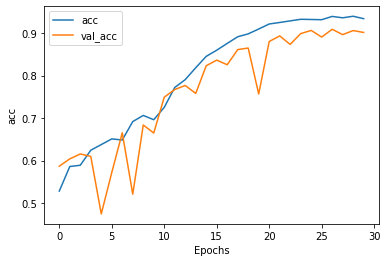

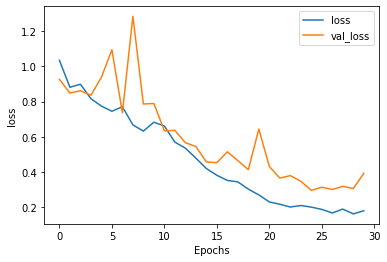

In [67]:
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

# Model 2

In [0]:
# Initializing parameters
epochs = 30
batch_size = 100
n_hidden = 32

In [69]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.70))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [71]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 8s 1ms/step - loss: 1.5767 - acc: 0.3376 - val_loss: 1.4419 - val_acc: 0.4299
Epoch 2/30
7352/7352 [==============================] - 7s 976us/step - loss: 1.3600 - acc: 0.4294 - val_loss: 1.3160 - val_acc: 0.5348
Epoch 3/30
7352/7352 [==============================] - 7s 954us/step - loss: 1.2362 - acc: 0.5046 - val_loss: 1.1664 - val_acc: 0.5568
Epoch 4/30
7352/7352 [==============================] - 7s 957us/step - loss: 1.1097 - acc: 0.5540 - val_loss: 1.0417 - val_acc: 0.6176
Epoch 5/30
7352/7352 [==============================] - 7s 990us/step - loss: 1.0189 - acc: 0.5783 - val_loss: 0.9539 - val_acc: 0.6250
Epoch 6/30
7352/7352 [==============================] - 7s 961us/step - loss: 0.9512 - acc: 0.5883 - val_loss: 0.8754 - val_acc: 0.6369
Epoch 7/30
7352/7352 [==============================] - 7s 944us/step - loss: 0.9014 - acc: 0.6084 - val_loss: 0.9026 - val_acc: 0.6121
Ep

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 512        0        25        0                   0   
SITTING                  3      410        75        0                   0   
STANDING                 0       87       445        0                   0   
WALKING                  0        0         0      481                   2   
WALKING_DOWNSTAIRS       0        0         0        0                 382   
WALKING_UPSTAIRS         0        0         0        2                  18   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            3  
STANDING                           0  
WALKING                           13  
WALKING_DOWNSTAIRS                38  
WALKING_UPSTAIRS                 451  


In [72]:
score_model2 = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 318us/step


In [73]:
score_model2

[0.6685546384824103, 0.6284356973193078]

In [0]:
#https://github.com/sunneysood/Tensorflow/blob/master/Multi_Layer_LSTM.ipynb
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

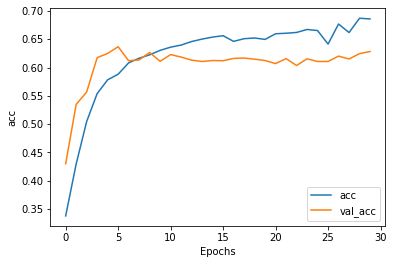

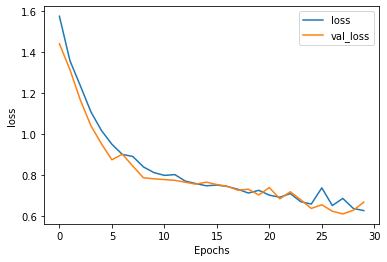

In [75]:
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

- With a simple 2 layer architecture and high dropout we got 62.85% accuracy and a loss of 0.66

# Model 3

In [0]:
# Initializing parameters
epochs = 30
batch_size = 100
n_hidden = 128

In [78]:
# Initiliazing the sequential model
from keras.layers import BatchNormalization
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim),return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.65))
model.add(BatchNormalization())
model.add(LSTM(n_hidden - 32))
model.add(Dropout(0.55))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128, 128)          70656     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 128)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128)          512       
_________________________________________________________________
lstm_8 (LSTM)                (None, 96)                86400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 582       
Total params: 158,150
Trainable params: 157,894
Non-trainable params: 256
______________________________________________

In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [80]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 54s 7ms/step - loss: 1.0240 - acc: 0.5834 - val_loss: 0.7480 - val_acc: 0.7139
Epoch 2/30
7352/7352 [==============================] - 51s 7ms/step - loss: 0.6771 - acc: 0.7376 - val_loss: 0.5999 - val_acc: 0.7835
Epoch 3/30
7352/7352 [==============================] - 51s 7ms/step - loss: 0.4513 - acc: 0.8483 - val_loss: 0.4842 - val_acc: 0.8229
Epoch 4/30
7352/7352 [==============================] - 51s 7ms/step - loss: 0.3053 - acc: 0.9045 - val_loss: 0.5487 - val_acc: 0.8476
Epoch 5/30
7352/7352 [==============================] - 51s 7ms/step - loss: 0.2376 - acc: 0.9226 - val_loss: 0.4485 - val_acc: 0.8541
Epoch 6/30
7352/7352 [==============================] - 52s 7ms/step - loss: 0.2032 - acc: 0.9302 - val_loss: 0.3268 - val_acc: 0.8884
Epoch 7/30
7352/7352 [==============================] - 51s 7ms/step - loss: 0.1709 - acc: 0.9384 - val_loss: 0.2953 - val_acc: 0.9030
Epoch 8

In [82]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 537        0  ...                   0                 0
SITTING                  5      418  ...                   0                 2
STANDING                 0       87  ...                   0                 0
WALKING                  0        0  ...                  28                 3
WALKING_DOWNSTAIRS       0        0  ...                 420                 0
WALKING_UPSTAIRS         0        0  ...                  17               437

[6 rows x 6 columns]


In [83]:
score_model3 = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 5s 2ms/step


In [84]:
score_model3

[0.388978390800617, 0.9219545300305395]

In [0]:
#https://github.com/sunneysood/Tensorflow/blob/master/Multi_Layer_LSTM.ipynb
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

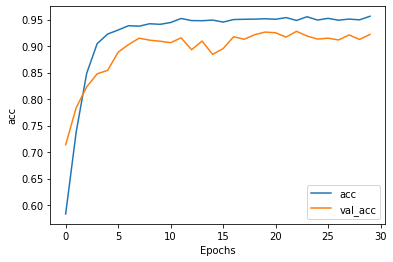

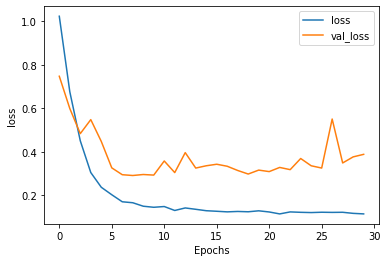

In [86]:
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

- With a simple 2 layer architecture we got 92.19% accuracy and a loss of 0.38


# Conclusion

In [87]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Test Loss", "Test Accuracy"]

x.add_row(["Increase LSTM Units",score_model1[0],score_model1[1]])
x.add_row(["Increase Dropouts",score_model2[0],score_model2[1]])
x.add_row(["Increase LSTM Layers with increased Dropouts",score_model3[0],score_model3[1]])
print(x)



+----------------------------------------------+---------------------+--------------------+
|                    Model                     |      Test Loss      |   Test Accuracy    |
+----------------------------------------------+---------------------+--------------------+
|             Increase LSTM Units              | 0.39255878280461215 | 0.9015948422124194 |
|              Increase Dropouts               |  0.6685546384824103 | 0.6284356973193078 |
| Increase LSTM Layers with increased Dropouts |  0.388978390800617  | 0.9219545300305395 |
+----------------------------------------------+---------------------+--------------------+
